# Tutorial 7: Linear Optimisation Methods

In this tutorial, we'll take a closer look at solving inverse problems using linear optimization. Unlike the Bayesian methods, which seek a full probability distribution, these methods aim to find a single, optimal "best-fit" model.

We will revisit the problem from Tutorial 1: estimating a smooth function on a circle from sparse, noisy point data.

The two main methods we'll explore are:
1.  **Tikhonov-Regularized Least Squares:** This method balances fitting the data and controlling the norm of the solution via a manually chosen damping parameter, `α`.
2.  **Minimum Norm (Discrepancy Principle):** This method automatically finds the optimal damping parameter `α` such that the data is fit to a statistically acceptable level.

Our goal is to understand how these methods work and see the effect of the regularization parameter.

In [1]:
# To run in colab, uncomment the line below to install pygeoinf. 
#%pip install pygeoinf

import numpy as np
import matplotlib.pyplot as plt
import pygeoinf as inf
from pygeoinf.symmetric_space.circle import Sobolev, CircleHelper

# For reproducibility
np.random.seed(42)

## 1. Setting up the Problem

First, let's set up the same inverse problem as in Tutorial 1. We have a `Sobolev` space for our model, a `point_evaluation_operator` as our forward map, and a `GaussianMeasure` for the data noise. We then generate a "true" model and synthetic data.

In [2]:
# --- Setup the forward problem (same as Tutorial 1) ---
model_space = Sobolev.from_sobolev_parameters(2.0, 0.05)
n_data = 20
observation_points = model_space.random_points(n_data)
forward_operator = model_space.point_evaluation_operator(observation_points)
data_space = forward_operator.codomain
standard_deviation = 0.1
data_error_measure = inf.GaussianMeasure.from_standard_deviation(
    data_space, standard_deviation
)
forward_problem = inf.LinearForwardProblem(
    forward_operator, data_error_measure=data_error_measure
)

# --- Generate synthetic data ---
model_prior_measure = model_space.point_value_scaled_heat_kernel_gaussian_measure(
    scale=0.1, amplitude=1.0
)
true_model, data = forward_problem.synthetic_model_and_data(model_prior_measure)

print("Forward problem and synthetic data are ready.")

Forward problem and synthetic data are ready.


## 2. Method 1: Tikhonov-Regularized Least Squares

The `LinearLeastSquaresInversion` method solves the problem by minimizing the Tikhonov functional:

$$
J(u) = \|A(u) - d\|^2_{C_e^{-1}} + \alpha^2 \|u\|^2
$$

Here, `α` is the **damping parameter**. It controls the trade-off:
* A **small `α`** trusts the data more, leading to a solution with a small data misfit but potentially a large norm (and oscillatory artifacts).
* A **large `α`** trusts the prior knowledge more (that the solution should be "small"), leading to a smooth, low-norm solution that may not fit the data well.

The choice of `α` is critical and often requires experimentation. Let's solve the problem for three different values of `α`.

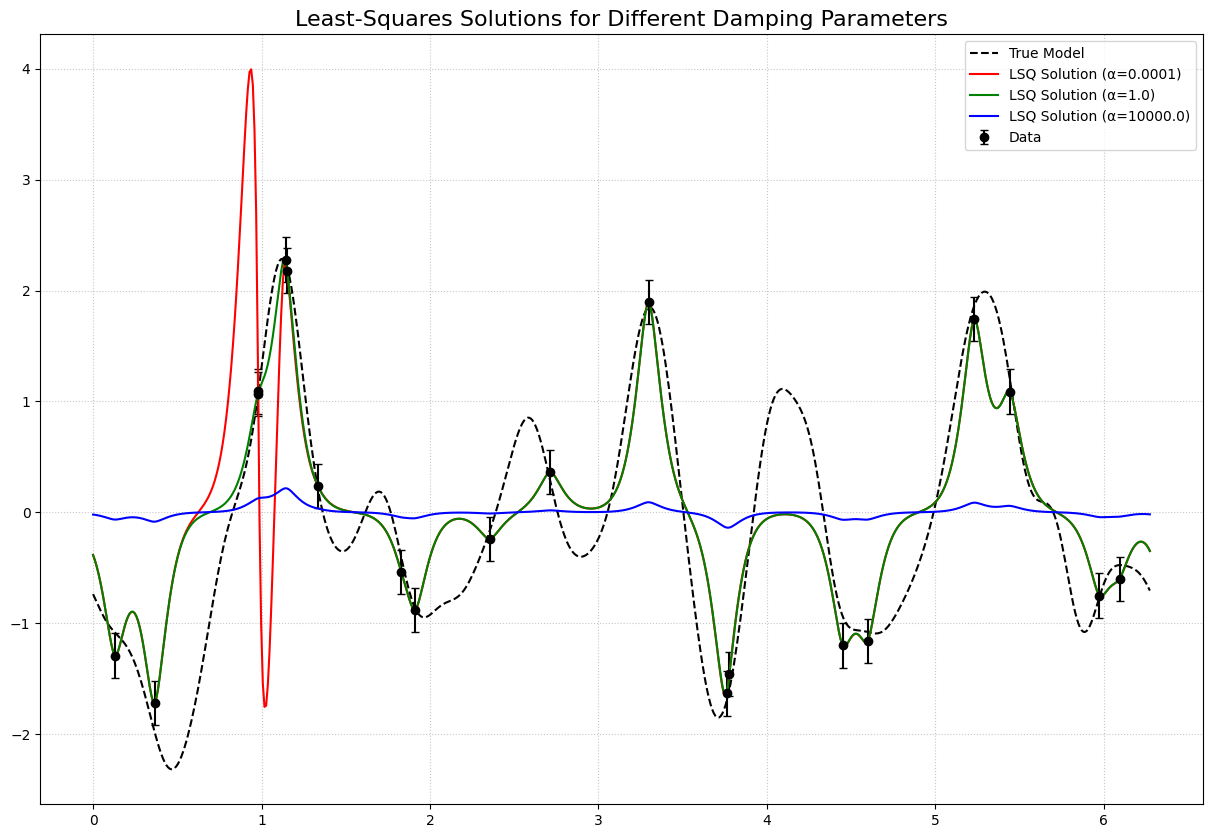

In [3]:
# Set up the inversion object
lsq_inversion = inf.LinearLeastSquaresInversion(forward_problem)
solver = inf.CGSolver(rtol=1e-9)

# --- Solve for different damping parameters ---
damping_values = [ 1e-4, 1e0, 1e4]
lsq_solutions = {}

for alpha in damping_values:
    # Get the operator that maps data to the least-squares solution for this alpha
    lsq_operator = lsq_inversion.least_squares_operator(alpha, solver)
    solution = lsq_operator(data)
    lsq_solutions[alpha] = solution

# --- Plot the results ---
fig, ax = model_space.plot(true_model, color="k", linestyle="--", label="True Model", figsize=(15, 10))
ax.errorbar(observation_points, data, 2 * standard_deviation, fmt="ko", capsize=3, label="Data")

colors = ['r', 'g', 'b']
for (alpha, solution), color in zip(lsq_solutions.items(), colors):
    model_space.plot(solution, fig=fig, ax=ax, color=color, label=f'LSQ Solution (α={alpha})')

ax.set_title("Least-Squares Solutions for Different Damping Parameters", fontsize=16)
ax.legend()
ax.grid(True, linestyle=":", alpha=0.7)
plt.show()

As you can see, the very small damping parameter (`α=1e-4`) "over-fits" the noisy data, leading to an oscillatory solution. The very large damping parameter (`α=1e4`) "under-fits" the data, leading to a solution that is too smooth and close to zero. The intermediate value (`α=1e0`) appears to be a good compromise.

This highlights the main challenge of this method: choosing the right `α`.

## 3. Method 2: Minimum Norm Solution via Discrepancy Principle

The `LinearMinimumNormInversion` method provides an automated way to choose the damping parameter. It uses the **discrepancy principle**, which aims to find the model with the *smallest possible norm* that still fits the data to a statistically plausible degree.

It works by finding the `α` such that the chi-squared misfit is equal to its expected value (the number of data points):
$$
\chi^2(u_\alpha, d) \approx N_{data}
$$
This is done internally using a bracketing search.

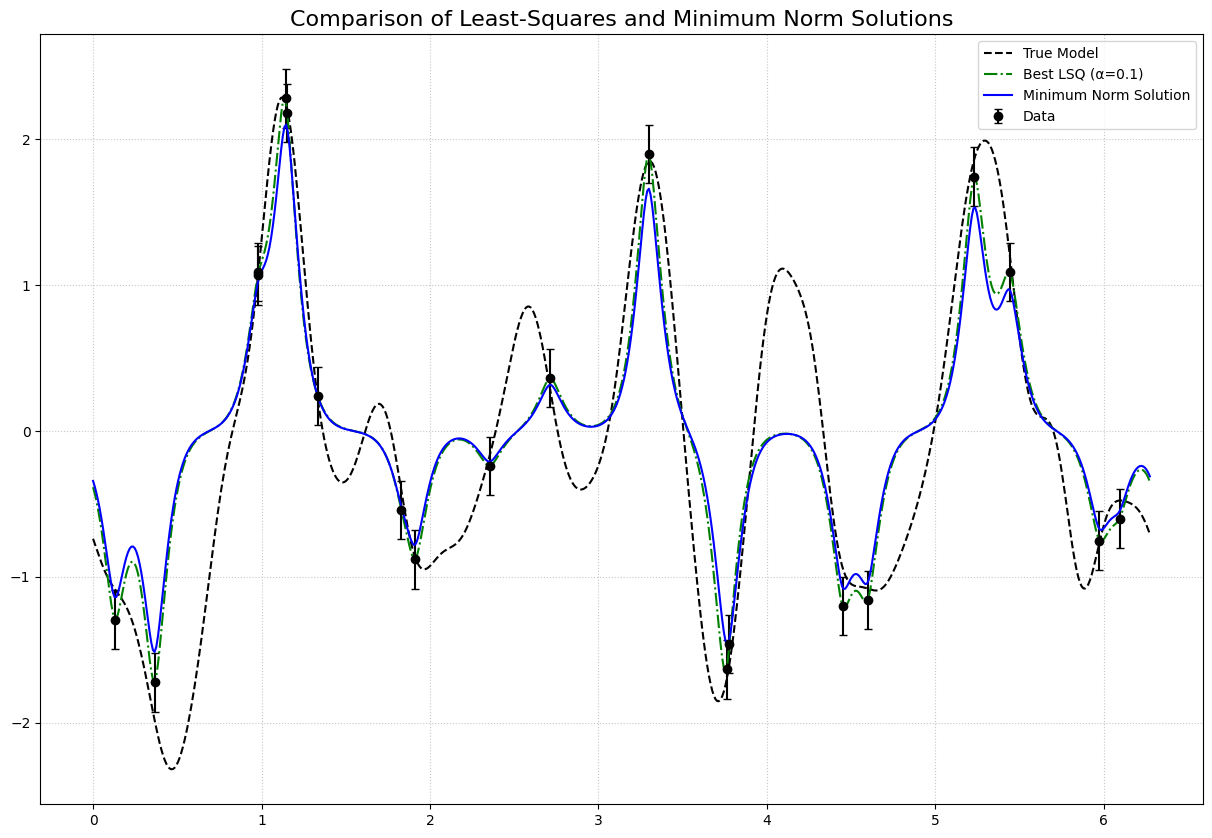

In [4]:
# Set up the inversion method
min_norm_inversion = inf.LinearMinimumNormInversion(forward_problem)

# Get the operator that maps data to the solution.
# This operator will contain the logic to automatically find the best damping.
min_norm_operator = min_norm_inversion.minimum_norm_operator(solver)

# Compute the minimum norm model
min_norm_model = min_norm_operator(data)

# --- Plot the results and compare ---
fig, ax = model_space.plot(true_model, color="k", linestyle="--", label="True Model", figsize=(15, 10))
ax.errorbar(observation_points, data, 2 * standard_deviation, fmt="ko", capsize=3, label="Data")

# Plot the best least-squares solution from before for comparison
model_space.plot(lsq_solutions[1], fig=fig, ax=ax, color='g', linestyle='-.', label='Best LSQ (α=0.1)')

# Plot the new minimum norm solution
model_space.plot(min_norm_model, fig=fig, ax=ax,  color='b', label='Minimum Norm Solution')

ax.set_title("Comparison of Least-Squares and Minimum Norm Solutions", fontsize=16)
ax.legend()
ax.grid(True, linestyle=":", alpha=0.7)
plt.show()

The minimum norm solution is very similar to our "best guess" from the manual Tikhonov method. This demonstrates its power: it provides a robust, automated way to achieve a well-regularized solution without the need for manual parameter tuning.